# Recordatorio distribución de Poisson

$$X \sim Poisson(\lambda)$$

$$P(X=k)=\frac{\lambda ^{k}e^{-\lambda }}{k!}$$

para $k = 0, 1, 2,..$

La distribución de Poisson es una distribución de probabilidad discreta que expresa, a partir de una frecuencia de ocurrencia media, la probabilidad de que ocurra un determinado número de eventos durante cierto período de tiempo. Concretamente, se especializa en la probabilidad de ocurrencia de sucesos con probabilidades muy pequeñas, o sucesos raros. 

In [1]:
from scipy.stats import poisson        # distribucion de poisson

import pylab as plt
import seaborn as sns

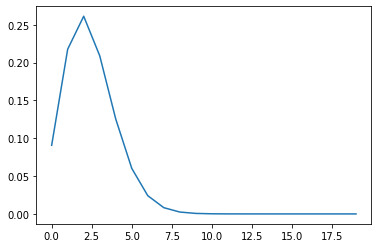

In [2]:
x=[i for i in range(20)]  # nº de sucesos, eje x

lamb=2.4  # media de ocurrencia

y=[poisson.pmf(x, lamb) for x in x]   # evaluacion de la pmf para cada nº de sucesos, eje y

plt.plot(x, y);

# Modelo de Dixon-Coles (Maher)

La idea detrás del modelo de [Dixon-Coles](http://web.math.ku.dk/~rolf/teaching/thesis/DixonColes.pdf) es que el gol es un evento raro en un partido de fútbol y se podría usar la distribución de Poisson para predecir el resultado de un partido.


Para el nº de goles X del equipo local i-esimo y el nº de goles Y del equipo visitante j-esimo se tendria:

$$X \sim Poisson(\lambda)$$

$$P(X=k)=\frac{\lambda^{k}e^{-\lambda}}{k!}$$

$$Y \sim Poisson(\mu)$$

$$P(Y=k)=\frac{\mu^{k}e^{-\mu}}{k!}$$

donde:

$\lambda = \gamma\alpha_{i}\beta_{j} = \exp^{(\gamma+\alpha_{i}+\beta_{j})}$

$\mu = \alpha_{j}\beta_{i}  = \exp^{(\alpha_{j}+\beta_{i})}$

El modelo introduce varios parámetros para relacionar los equipos y los partidos, un parámetro llamado `gamma` es el parámetro de jugar en casa, los parámetros llamados `alfa` son los parámetros de ataque de cada equipo y los parámetros `beta` son los de defensa de cada equipo.

Asi pues, la funcion que define el partido, la funcion principal del modelo, nuestro `predict` es:

$$P(X=x, Y=y)=\frac{\lambda^{x}e^{-\lambda}}{x!} · \frac{\mu^{y}e^{-\mu}}{y!}$$

La funcion de coste o perdida, nuestro `fit`, en este caso se calcula con la [estamacion maximo verosimil](https://es.wikipedia.org/wiki/M%C3%A1xima_verosimilitud). Sería el productorio en todo el espacio de probabilidad de la funcion principal, llamada funcion de verosimilitud.

$$L(X=x, Y=y)=\prod_{i=1}^{n}\frac{\lambda^{x}e^{-\lambda}}{x!} · \frac{\mu^{y}e^{-\mu}}{y!}$$

Debido a la regla de la cadena, minimizar esta funcion es muy costoso, por lo que se realiza un truco matematico que consiste en aplicar el logaritmo. Esto es debido a la regla de los logaritmos: $log(a·b)=log(a)+log(b)$. Por tanto, la nueva funcion a ser optimizada (maximizada) es llamada log-verosimilitud.

$$l(X=x, Y=y)=\sum_{i=1}^{n}\log(\frac{\lambda^{x}e^{-\lambda}}{x!}) + \log(\frac{\mu^{y}e^{-\mu}}{y!})$$

La idea es: dados los resultados de los partidos de futbol, estimar el parametro de jugar en casa `gamma`, los parametros de ataque para cada equipo `alfa` y los parametros de defensa para cada equipo `beta`.

### Datos

Veamos primero la extracción de datos desde [aqui](https://www.football-data.co.uk/).

In [3]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
pd.set_option('display.max_columns', None)

In [4]:
df=pd.read_csv('https://www.football-data.co.uk/mmz4281/0001/SP1.csv')

df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,GBH,GBD,GBA,IWH,IWD,IWA,LBH,LBD,LBA,SBH,SBD,SBA,WHH,WHD,WHA
0,SP1,09/09/00,Barcelona,Malaga,2,1,H,2,0,H,1.28,3.90,7.90,1.25,4.3,8.0,1.35,3.75,8.0,1.30,4.33,8.50,1.28,4.50,8.00
1,SP1,09/09/00,La Coruna,Ath Bilbao,2,0,H,0,0,D,1.51,3.20,6.20,1.55,3.3,4.5,1.55,3.25,5.5,1.53,3.50,5.50,1.57,3.50,5.00
2,SP1,09/09/00,Real Madrid,Valencia,2,1,H,0,0,D,1.65,3.20,4.10,1.60,3.2,4.2,1.55,3.50,5.0,1.67,3.30,4.75,1.66,3.30,4.50
3,SP1,09/09/00,Sociedad,Santander,2,2,D,0,0,D,1.85,3.15,3.45,1.80,3.0,3.5,1.70,3.40,4.0,1.85,3.25,3.80,1.80,3.25,3.75
4,SP1,09/09/00,Zaragoza,Espanol,1,2,A,0,0,D,1.70,3.10,4.30,1.70,3.1,3.8,1.70,3.20,4.3,1.73,3.25,4.33,1.72,3.20,4.33


In [5]:
df=df[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]

df.shape

(380, 5)

In [6]:
for i in range(1, 22):
    
    year=''
    if i<9:
        year=f'0{i}0{i+1}'
    elif i==9:
        year=f'0{i}{i+1}'
    else:
        year=f'{i}{i+1}'
    
    n_df=pd.read_csv(f'https://www.football-data.co.uk/mmz4281/{year}/SP1.csv',
                    error_bad_lines=False,
                    warn_bad_lines=False)[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
    
    df=pd.concat([df, n_df])
    
df.shape

(8116, 5)

In [7]:
df.HomeTeam=df.HomeTeam.apply(lambda x: x.lower().replace(' ', '_'))
df.AwayTeam=df.AwayTeam.apply(lambda x: x.lower().replace(' ', '_'))

df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG
0,09/09/00,barcelona,malaga,2,1
1,09/09/00,la_coruna,ath_bilbao,2,0
2,09/09/00,real_madrid,valencia,2,1
3,09/09/00,sociedad,santander,2,2
4,09/09/00,zaragoza,espanol,1,2


In [8]:
df.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG
243,20/02/2022,espanol,sevilla,1,1
244,20/02/2022,valencia,barcelona,1,4
245,20/02/2022,betis,mallorca,2,1
246,20/02/2022,ath_bilbao,sociedad,4,0
247,21/02/2022,celta,levante,1,1


In [9]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8116 entries, 0 to 247
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      8116 non-null   object
 1   HomeTeam  8116 non-null   object
 2   AwayTeam  8116 non-null   object
 3   FTHG      8116 non-null   int64 
 4   FTAG      8116 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 1.7 MB


## Modelo de Poisson

**fit**

In [10]:
import numpy as np

from scipy.optimize import minimize    # minimizar funciones, optimizacion

In [11]:
# funcion de log-verosimilitud, funcion de perdida, optimizar para sacar los parametros

def loglike(x,  # goles de local 
            y,  # goles de visitante
            alfai, # ataque local
            betai, # defensa local
            alfaj, # ataque visitante
            betaj, # defensa visitante
            gamma  # jugar en casa
           ):
    
    
    # medias de cada equipo, es aqui donde podriamos añadir valores exogenos (clima, distancia recorrida, etc...)
    lamb=np.exp(gamma + alfai + betaj) # local
    mu=np.exp(alfaj + betai) # visitante
    
    
    l=(np.log(poisson.pmf(x, lamb)) + np.log(poisson.pmf(y, mu)))
    
    return l

In [21]:
# funcion fit, para obtener alfas, betas y gamma

def fit(data):

    #data=df.iloc[-40:]

    equipos=np.sort(data.HomeTeam.unique())

    n_equipos=len(equipos)



    # inicilizar los parametros, de existir valores exogenos necesitarian su propio parametro

    val_inicial=np.concatenate((np.random.uniform(0, 1, (n_equipos)),  # alfas iniciales
                                np.random.uniform(0, -1, (n_equipos)), # betas iniciales
                                np.random.uniform(0, 1, (n_equipos)))) # gammas inicial




    def menos_loglike(params): # funcion a minimizar

        alfa_coefs=dict(zip(equipos, params[:n_equipos]))  # alfas ataque

        beta_coefs=dict(zip(equipos, params[n_equipos:(2*n_equipos)])) # betas defensa

        gamma_coefs=dict(zip(equipos, params[(2*n_equipos):(3*n_equipos)])) # jugar en casa

        log_like=[loglike(dato.FTHG,
                          dato.FTAG,
                          alfa_coefs[dato.HomeTeam],
                          beta_coefs[dato.HomeTeam],
                          alfa_coefs[dato.AwayTeam],
                          beta_coefs[dato.AwayTeam],
                          gamma_coefs[dato.HomeTeam]) for dato in data.itertuples()]  # seleccion por filas de los datos

        return -sum(log_like)


    #minimizacion

    optimizacion=minimize(menos_loglike, # funcion a minimizar
                          val_inicial,
                          method='trust-constr',
                          options={'disp':True,'maxiter':100},
                          #constraints=[{'type':'eq','fun':lambda x:sum(x[:20])-20}]
                          )

    return dict(zip(['alfa_'+equipo for equipo in equipos]+
                    ['beta_'+equipo for equipo in equipos]+
                    ['gamma_'+equipo for equipo in equipos],
              optimizacion.x))

In [23]:
%%time

data=df.iloc[-40:]

params=fit(data)

params

The maximum number of function evaluations is exceeded.
Number of iterations: 100, function evaluations: 6100, CG iterations: 696, optimality: 6.66e-03, constraint violation: 0.00e+00, execution time: 3.3e+01 s.
CPU times: user 58.1 s, sys: 1min 42s, total: 2min 40s
Wall time: 33.3 s


{'alfa_alaves': -0.24759127680198828,
 'alfa_ath_bilbao': 0.5121570395659109,
 'alfa_ath_madrid': 3.0348118122138685,
 'alfa_barcelona': 0.917200525316251,
 'alfa_betis': 2.1936225788735655,
 'alfa_cadiz': 0.7367921435175516,
 'alfa_celta': 2.762072214184603,
 'alfa_elche': 2.0394718743697013,
 'alfa_espanol': 2.6454047038312436,
 'alfa_getafe': 0.7660739657964838,
 'alfa_granada': -7.011265264605378,
 'alfa_levante': -0.5607190564710884,
 'alfa_mallorca': 0.3390791883564513,
 'alfa_osasuna': 1.072688737273057,
 'alfa_real_madrid': -5.071238257687412,
 'alfa_sevilla': 0.7375238982240322,
 'alfa_sociedad': -8.026164519462682,
 'alfa_valencia': 0.204540847097529,
 'alfa_vallecano': -0.6506100697505849,
 'alfa_villarreal': 1.403316953959535,
 'beta_alaves': -0.0791808049948559,
 'beta_ath_bilbao': -2.648273141242695,
 'beta_ath_madrid': 0.4188786950143168,
 'beta_barcelona': -2.0490781824999975,
 'beta_betis': -0.5529750650225473,
 'beta_cadiz': -3.054275332362734,
 'beta_celta': -0.20659

In [18]:
# valor de jugar en casa

np.exp(0.24)

1.2712491503214047

**predict**

In [25]:
# funciones para prediccion

def predict_matrix(params, local, visitante, g_max=9):
    
    # se define las medias
    
    lamb=np.exp(params['gamma_'+local] + params['alfa_'+local] + params['beta_'+visitante])
    mu=np.exp(params['alfa_'+visitante] + params['beta_'+local])
    
    avgs=[lamb, mu]
    
    pred=[[poisson.pmf(i, avg) for i in range(g_max+1)] for avg in avgs]
    
    matriz=np.outer(np.array(pred[0]), np.array(pred[1]))
    
    return matriz

In [26]:
partido=predict_matrix(params, 'vallecano', 'real_madrid')

In [27]:
pd.DataFrame(partido)

,0,1,2,3,4,5,6,7,8,9
0,9.938217e-01,5.061823e-03,1.289067e-05,2.188532e-08,2.786707e-11,2.838703e-14,2.409723e-17,1.753346e-20,1.116288e-23,6.317311e-27
1,1.097383e-03,5.589294e-06,1.423395e-08,2.416589e-11,3.077098e-14,3.134511e-17,2.660830e-20,1.936055e-23,1.232611e-26,6.975610e-30
2,6.058684e-07,3.085865e-09,7.858604e-12,1.334205e-14,1.698874e-17,1.730572e-20,1.469052e-23,1.068901e-26,6.805281e-30,3.851253e-33
3,2.230011e-10,1.135810e-12,2.892505e-15,4.910790e-18,6.253021e-21,6.369692e-24,5.407116e-27,3.934288e-30,2.504810e-33,1.417525e-36
4,6.155976e-14,3.135418e-16,7.984799e-19,1.355630e-21,1.726155e-24,1.758362e-27,1.492642e-30,1.086066e-33,6.914562e-37,3.913098e-40
5,1.359493e-17,6.924292e-20,1.763372e-22,2.993789e-25,3.812060e-28,3.883187e-31,3.296367e-34,2.398480e-37,1.527020e-40,8.641729e-44
6,2.501932e-21,1.274307e-23,3.245208e-26,5.509598e-29,7.015497e-32,7.146394e-35,6.066445e-38,4.414024e-41,2.810239e-44,1.590374e-47
7,3.946639e-25,2.010138e-27,5.119110e-30,8.691040e-33,1.106650e-35,1.127298e-38,9.569431e-42,6.962843e-45,4.432974e-48,2.508714e-51
8,5.447376e-29,2.774507e-31,7.065688e-34,1.199587e-36,1.527461e-39,1.555961e-42,1.320827e-45,9.610513e-49,6.118643e-52,3.462670e-55
9,6.683359e-33,3.404029e-35,8.668857e-38,1.471767e-40,1.874035e-43,1.909001e-46,1.620517e-49,1.179109e-52,7.506933e-56,4.248333e-59


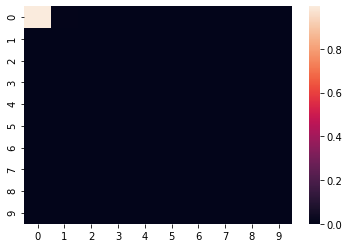

In [28]:
sns.heatmap(partido);

In [29]:
uno=np.sum(np.tril(partido, -1))

empate=np.sum(np.diag(partido))

dos=np.sum(np.triu(partido, 1))

In [30]:
uno, empate, dos

(0.001097992583441498, 0.9938272570962491, 0.005074750320309346)

In [31]:
uno+empate+dos

0.9999999999999999

In [32]:
1/uno, 1/empate, 1/dos  # cuotas calculadas

(910.752964164517, 1.0062110823180543, 197.0540296333322)

In [37]:
1/4.3 + 1/3.6 + 1/1.81

1.0628221051579654

In [33]:
def predict_proba(params, local, visitante, g_max=9):
    
    partido=predict_matrix(params, local, visitante, g_max)
    
    uno=np.sum(np.tril(partido, -1))

    empate=np.sum(np.diag(partido))

    dos=np.sum(np.triu(partido, 1))
    
    return uno, empate, dos

In [34]:
predict_proba(params, 'vallecano', 'real_madrid')# probabilidad (1, X, 2)

(0.001097992583441498, 0.9938272570962491, 0.005074750320309346)

In [35]:
def predict(params, local, visitante, g_max=9):
    
    prob=predict_proba(params, local, visitante, g_max)
    
    return prob.index(max(prob))

In [36]:
predict(params, 'vallecano', 'real_madrid')  # etiquetas: 0-gana local , 1-empate, 2-gana visitante

1

**Walk-Forward BackTesting**

![wfbt](images/wfbt.gif)